libraries

In [1]:
%matplotlib inline
import os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from skimage.draw import ellipse
from skimage.filters import gaussian

import dezero
import dezero.layers as L
import dezero.functions as F
from dezero.models import Model, Model_stepby
from dezero.optimizers import Adam
from dezero.dataloaders import DataLoader

from glob import glob
import itertools

parameters

In [2]:
np.random.seed(0) 
image_size = 64
num_train_image, num_test_image = 256*128, 256*8
max_gray = 255.

batchsize = 128

use_gpu = dezero.cuda.gpu_enable
is_training = True

train_latent = 3
test_latent = train_latent
lambda_cov = 4
lambda_rec = 1
num_epoch = 30
lr = 0.001

create grayscale ellipse images

In [3]:
def generating_data(num_image,image_size=64,max_gray=255,save_training_image=False,path_data='.'):
    # Random set of radius and rotation coefficients
    set_radius_x = np.random.randint(image_size/32, image_size/2, size=num_image)
    set_radius_y = np.random.randint(image_size/32, image_size/2, size=num_image)
    set_rotation = np.random.randint(0, 90, size=num_image)
    
    list_image = []    

    for n_image in range(num_image):
        img = np.zeros((image_size, image_size), dtype=np.uint8)
        radius_x = set_radius_x[n_image]
        radius_y = set_radius_y[n_image]
        rotation = set_rotation[n_image]

        rr, cc = ellipse(image_size/2, image_size/2, radius_x, radius_y, rotation=np.deg2rad(rotation))
        img[rr, cc] = max_gray
        img = gaussian(img, sigma=0.5, preserve_range=True)

        list_image.append(np.expand_dims(np.expand_dims(img,0),0))

    list_image = np.concatenate(list_image,0)
    return list_image
                    
train_images =  generating_data(num_train_image,image_size=image_size,max_gray=max_gray)
test_images =  generating_data(num_test_image,image_size=image_size,max_gray=max_gray)

In [4]:
print(train_images.shape)
print(np.min(train_images),np.max(train_images))

(32768, 1, 64, 64)
0.0 255.0


In [5]:
train_dataset = (train_images/max_gray)
test_dataset = (test_images/max_gray)
train_loader = DataLoader(train_dataset, batchsize, label=False)
test_loader = DataLoader(test_dataset, batchsize, shuffle=False, label=False)

batch_idx 0
(128, 1, 64, 64)
<class 'numpy.ndarray'>


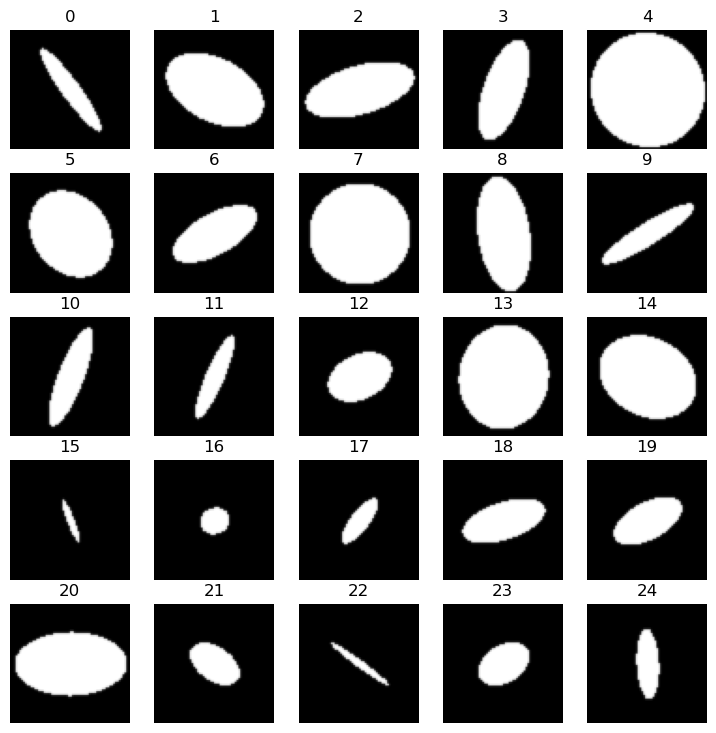

In [6]:
img_plot_size = 5
img_sample_num = int(img_plot_size**2)

plt.figure(figsize=(9, 9))
for batch_idx, data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print(data.shape)
    print(type(data))
    for i in range(img_sample_num):
        ax = plt.subplot(img_plot_size, img_plot_size, i + 1)
        ax.title.set_text('{}'.format(i))
        img = data[i].reshape(image_size,image_size)
        plt.imshow(img, 'gray')
        plt.axis("off")
    if batch_idx == 0:
        break

encoder and decoder

In [7]:
class Encoder(Model):
    def __init__(self, code_size=1, kernel_size=4):
        super().__init__()
        
        cnn_kwargs = dict(stride=2, pad=1)
        self.conv1 = L.Conv2d(int(code_size*32), kernel_size, **cnn_kwargs)
        self.conv2 = L.Conv2d(int(code_size*16), kernel_size, **cnn_kwargs)
        self.conv3 = L.Conv2d(int(code_size*8), kernel_size, **cnn_kwargs)
        self.conv4 = L.Conv2d(int(code_size*4), kernel_size, **cnn_kwargs)
        self.conv5 = L.Conv2d(int(code_size*2), kernel_size, **cnn_kwargs)
        self.conv6 = L.Conv2d(code_size, kernel_size, **cnn_kwargs)
        self.zero_mean = L.BatchNorm(eps=0, affine=False, track_running_stats=True)
        
    def forward(self, x):
        batch_size = len(x)

        x = F.leaky_relu(self.conv1(x), slope=0.2)
        x = F.leaky_relu(self.conv2(x), slope=0.2)
        x = F.leaky_relu(self.conv3(x), slope=0.2)
        x = F.leaky_relu(self.conv4(x), slope=0.2)
        x = F.leaky_relu(self.conv5(x), slope=0.2)
        x = self.conv6(x)
        z = x.reshape(batch_size, -1)
        z = self.zero_mean(z)
        return z  

In [8]:
class Decoder(Model):
    def __init__(self, code_size=1, kernel_size=4, n_chan=1):
        super().__init__()
        # Shape required to start transpose convs
        self.reshape = (code_size, 1, 1)
         
        cnn_kwargs = dict(stride=2, pad=1)
        self.convT6 = L.Deconv2d(int(code_size*2), kernel_size, **cnn_kwargs)
        self.convT5 = L.Deconv2d(int(code_size*4), kernel_size, **cnn_kwargs)
        self.convT4 = L.Deconv2d(int(code_size*8), kernel_size, **cnn_kwargs)
        self.convT3 = L.Deconv2d(int(code_size*16), kernel_size, **cnn_kwargs)
        self.convT2 = L.Deconv2d(int(code_size*32), kernel_size, **cnn_kwargs)
        self.convT1 = L.Deconv2d(n_chan, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = len(z)
        
        x = z.reshape(batch_size, *self.reshape)
        
        x = F.leaky_relu(self.convT6(x), slope=0.2)
        x = F.leaky_relu(self.convT5(x), slope=0.2)
        x = F.leaky_relu(self.convT4(x), slope=0.2)
        x = F.leaky_relu(self.convT3(x), slope=0.2)
        x = F.leaky_relu(self.convT2(x), slope=0.2)
        # Sigmoid activation for final conv layer
        x = F.sigmoid(self.convT1(x))

        return x

reconstruction loss

In [9]:
def reconstruction_loss(data_rec, data, MSE=False):
    if MSE:
        return F.mean_squared_error(data_rec, data)
    else:
        return F.binary_cross_entropy(data_rec, data)

train a vanilla autoencoder

In [10]:
class AE(Model):
    def __init__(self, code_size=1, kernel_size=4, n_chan = 1):
        super().__init__()
        self.encoder = Encoder(code_size, kernel_size)
        self.decoder = Decoder(code_size, kernel_size, n_chan)

    def forward(self, data):
        
        z = self.encoder(data)
        data_rec = self.decoder(z)
        
        return data_rec

In [11]:
def train_AE(AE, optimizer, epoch, train_loader, test_loader):
    train_loss = 0.    
    test_loss = 0.
    
    for batch_idx, data in enumerate(train_loader):
        data_rec = AE(data)
        loss = reconstruction_loss(data_rec, data)
        AE.cleargrads()
        loss.backward()
        optimizer.update()

        train_loss += loss.data

    with dezero.no_grad():
        for batch_idx, data in enumerate(test_loader):
            data_rec = AE(data)
            loss = reconstruction_loss(data_rec, data)

            test_loss += loss.data
            
            if epoch % 5 == 0 and batch_idx == 0:
                xp = dezero.cuda.get_array_module(data)
                choice = np.random.choice(np.arange(len(data), dtype=int), size=5, replace=False)
                
                fig, axes = plt.subplots(5, 2, figsize=(9, 9))
                for num, i in enumerate(choice):
                    img, img_rec = data[i], data_rec[i].data
                    if xp == cp:
                        img, img_rec = cp.asnumpy(img), cp.asnumpy(img_rec)
                    img, img_rec = np.squeeze(img, axis=0), np.squeeze(img_rec, axis=0)
                    
                    axes[num, 0].imshow(img, 'gray')
                    axes[num, 0].title.set_text(f"{i} origin")
                    axes[num, 0].axis('off')
                    axes[num, 1].imshow(img_rec, 'gray')
                    axes[num, 1].title.set_text(f"{i} rec")
                    axes[num, 1].axis('off')
                plt.show()
                    
    print('====> AE Epoch: {}, Train loss: {:.6f}, Test loss: {:.6f}'
          .format(epoch, cp.asnumpy(train_loss / len(train_dataset)), cp.asnumpy(test_loss / len(test_dataset))))

In [12]:
simple_AE = AE(code_size=train_latent, kernel_size=4, n_chan = 1)

AE_optim = Adam(alpha=lr, beta1=0.5, beta2=0.999)

use gpu
Training AE for ellipses 

====> AE Epoch: 1, Train loss: 0.001412, Test loss: 0.000730
====> AE Epoch: 2, Train loss: 0.000708, Test loss: 0.000607
====> AE Epoch: 3, Train loss: 0.000562, Test loss: 0.000708
====> AE Epoch: 4, Train loss: 0.000462, Test loss: 0.000646


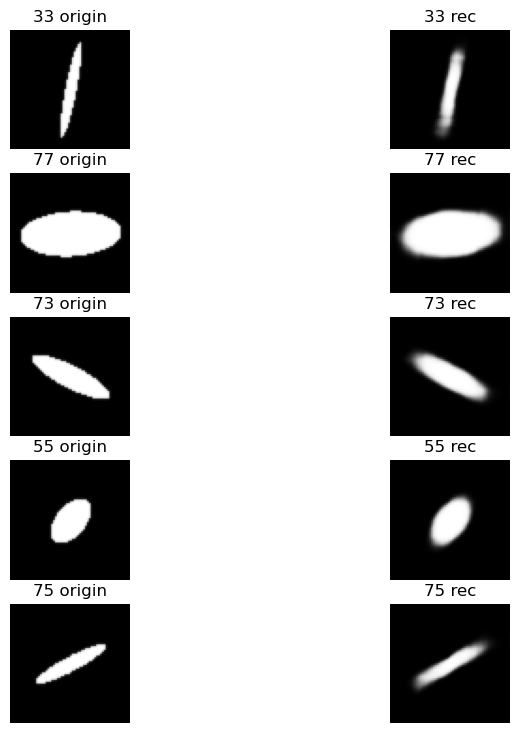

====> AE Epoch: 5, Train loss: 0.000443, Test loss: 0.000341
checkpoint - epoch: 5
parameters are saved 

====> AE Epoch: 6, Train loss: 0.000390, Test loss: 0.000342
====> AE Epoch: 7, Train loss: 0.000403, Test loss: 0.000476
====> AE Epoch: 8, Train loss: 0.000393, Test loss: 0.000314
====> AE Epoch: 9, Train loss: 0.000413, Test loss: 0.000416


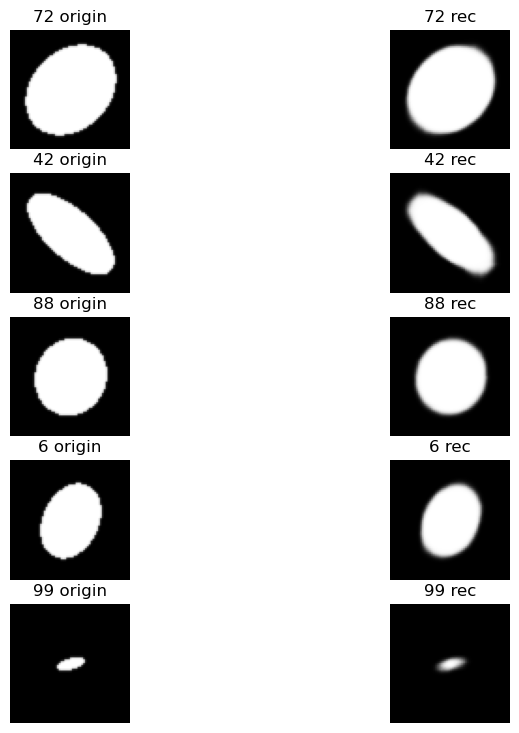

====> AE Epoch: 10, Train loss: 0.000378, Test loss: 0.000305
checkpoint - epoch: 10
parameters are saved 

====> AE Epoch: 11, Train loss: 0.000373, Test loss: 0.000266
====> AE Epoch: 12, Train loss: 0.000379, Test loss: 0.000431
====> AE Epoch: 13, Train loss: 0.000378, Test loss: 0.000283
====> AE Epoch: 14, Train loss: 0.000365, Test loss: 0.000264


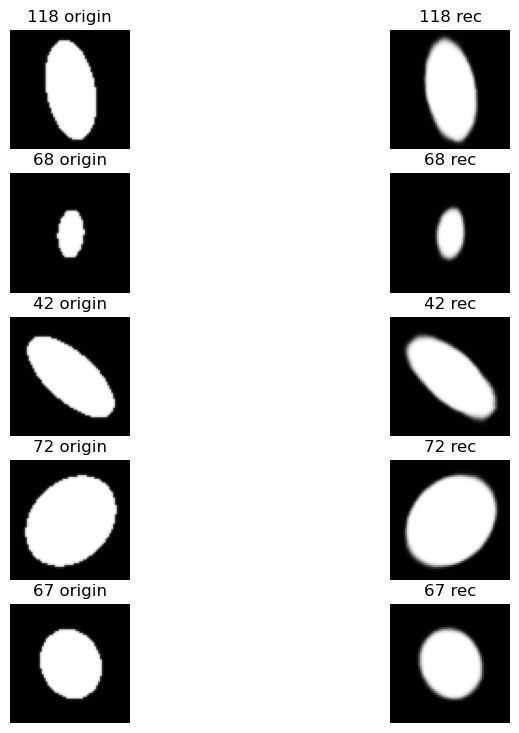

====> AE Epoch: 15, Train loss: 0.000362, Test loss: 0.000250
checkpoint - epoch: 15
parameters are saved 

====> AE Epoch: 16, Train loss: 0.000353, Test loss: 0.000312
====> AE Epoch: 17, Train loss: 0.000360, Test loss: 0.000255
====> AE Epoch: 18, Train loss: 0.000358, Test loss: 0.000250
====> AE Epoch: 19, Train loss: 0.000356, Test loss: 0.000488


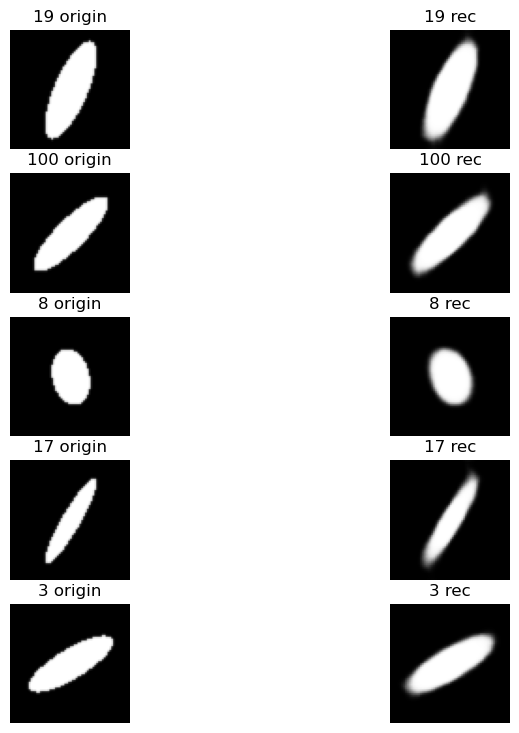

====> AE Epoch: 20, Train loss: 0.000357, Test loss: 0.000377
checkpoint - epoch: 20
parameters are saved 

====> AE Epoch: 21, Train loss: 0.000350, Test loss: 0.000276
====> AE Epoch: 22, Train loss: 0.000351, Test loss: 0.000269
====> AE Epoch: 23, Train loss: 0.000351, Test loss: 0.000384
====> AE Epoch: 24, Train loss: 0.000338, Test loss: 0.000293


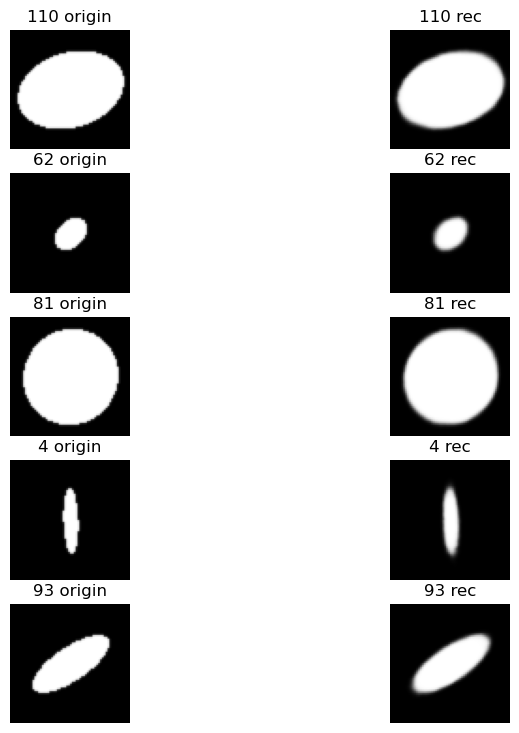

====> AE Epoch: 25, Train loss: 0.000350, Test loss: 0.000244
checkpoint - epoch: 25
parameters are saved 

====> AE Epoch: 26, Train loss: 0.000359, Test loss: 0.000309
====> AE Epoch: 27, Train loss: 0.000354, Test loss: 0.000273
====> AE Epoch: 28, Train loss: 0.000357, Test loss: 0.000239
====> AE Epoch: 29, Train loss: 0.000348, Test loss: 0.000229


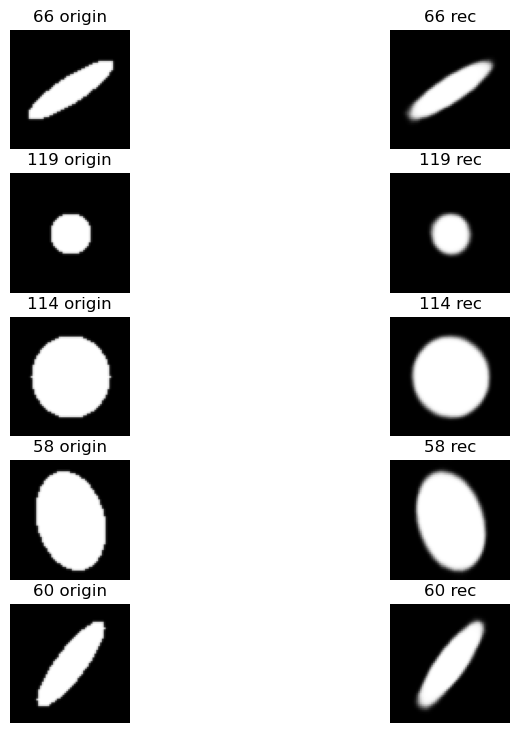

====> AE Epoch: 30, Train loss: 0.000345, Test loss: 0.000260
checkpoint - epoch: 30
parameters are saved 



In [13]:
simple_AE_path = './imit_models/simple_AE/'
if os.path.exists(simple_AE_path) is False:
    os.makedirs(simple_AE_path)
model_path_list = sorted(glob(f'{simple_AE_path}simple_AE_ellipse_*'), key=len)

if len(model_path_list) != 0:
    print('A trained model is found')
    is_training = False
    model_path = model_path_list[-1]

if use_gpu:
    simple_AE.to_gpu()
    train_loader.to_gpu()
    test_loader.to_gpu()
    print('use gpu')
else:
    print('use cpu')
    
if is_training:
    print("Training AE for ellipses", '\n')
    AE_optimizer = AE_optim.setup(simple_AE)
    for epoch in range(1, num_epoch + 1):
        train_AE(simple_AE, AE_optimizer, epoch, train_loader, test_loader)
    
        if epoch % 5 == 0:
            print(f'checkpoint - epoch: {epoch}')
            filename = f'simple_AE_ellipse_{epoch}.npz'
            filepath = os.path.join(simple_AE_path, filename)
            simple_AE.save_weights(filepath, BackToTheGPU=True)
            print('parameters are saved', '\n')

else:
    print(f"Load the model: {model_path}")
    simple_AE.load_weights(model_path)

covariance loss

In [14]:
def covariance_loss(z,step):
    if step>1:
        loss = 0
        for idx in range(step-1):
            loss += (F.mean(z[:,idx]*z[:,-1]))**2
            
        loss = loss/(step-1)
    else:
        xp = dezero.cuda.get_array_module(z)
        loss = dezero.Variable(xp.zeros_like(z.data))
    return F.mean(loss)

train PCA-like AE

In [15]:
class PCAAE_E(Model_stepby):
    def __init__(self, code_size=1, kernel_size=4, train_latent=3):
        super().__init__()
        
        PCAAE_E = []
        for id_m in range(train_latent):  
            PCAAE_E_i = Encoder(code_size, kernel_size)
            PCAAE_E.append(PCAAE_E_i)
        self.PCAAE_E = PCAAE_E

    def forward(self, data, step):
        z = []
        with dezero.no_grad():
            for jd in range(step-1):
                z.append(self.PCAAE_E[jd](data))
                
        z_i = self.PCAAE_E[step-1](data)
        z.append(z_i)
        
        latent_space = F.cat1Dcode(*z)
        return latent_space

In [16]:
class PCAAE_D(Model_stepby):
    def __init__(self, kernel_size=4, n_chan=1, train_latent=3):
        super().__init__()
        
        PCAAE_D = []
        for id_m in range(train_latent):  
            PCAAE_D_i = Decoder(id_m+1, kernel_size, n_chan)
            PCAAE_D.append(PCAAE_D_i)
        self.PCAAE_D = PCAAE_D
            
    def forward(self, latent_space, step):

        data_rec = self.PCAAE_D[step-1](latent_space)
        return data_rec

In [17]:
class PCAAE(Model_stepby):
    def __init__(self, code_size=1, kernel_size=4, n_chan=1, train_latent=3):
        super().__init__()
        
        self.PCAAE_E = PCAAE_E(code_size, kernel_size, train_latent)
        self.PCAAE_D = PCAAE_D(kernel_size, n_chan, train_latent)
        
    def forward(self, data, step):

        latent_space = self.PCAAE_E(data, step=step)
        data_rec = self.PCAAE_D(latent_space, step=step)

        return latent_space, data_rec

In [18]:
def train_PCA_AE(PCAAE, optimizer, epoch, step, train_loader, test_loader, 
                 lambda_rec=1, lambda_cov=1):
    train_loss = 0.    
    train_content_loss = 0.
    train_cov_loss = 0.
       
    test_loss = 0.   
    test_content_loss = 0.
    test_cov_loss = 0.       
    
    # Training part:
    for batch_idx, data in enumerate(train_loader):
        latent_space, data_rec = PCAAE(data, step=step)
        loss_data = lambda_rec * reconstruction_loss(data_rec, data)
        loss_cov = lambda_cov * covariance_loss(latent_space, step)
        loss = (loss_data + loss_cov)
        
        PCAAE.cleargrads()
        loss.backward()
        optimizer.update()
        
        train_loss += loss.data
        train_content_loss += loss_data.data
        if step>1:
            train_cov_loss +=  loss_cov.data
    
    # Testing part:
    with dezero.no_grad():
        for batch_idx, data in enumerate(test_loader):
            latent_space, data_rec = PCAAE(data, step=step)
            loss_data = lambda_rec * reconstruction_loss(data_rec, data)
            loss_cov = lambda_cov * covariance_loss(latent_space, step)
            loss = (loss_data + loss_cov)

            test_loss += loss.data
            test_content_loss += loss_data.data
            if step>1:
                test_cov_loss +=  loss_cov.data
                
            if epoch % 5 == 0 and batch_idx == 0:
                xp = dezero.cuda.get_array_module(data)
                choice = np.random.choice(np.arange(len(data), dtype=int), size=5, replace=False)
                
                fig, axes = plt.subplots(5, 2, figsize=(9, 9))
                for num, i in enumerate(choice):
                    img, img_rec = data[i], data_rec[i].data
                    if xp == cp:
                        img, img_rec = cp.asnumpy(img), cp.asnumpy(img_rec)
                    img, img_rec = np.squeeze(img, axis=0), np.squeeze(img_rec, axis=0)
                    axes[num, 0].imshow(img, 'gray')
                    axes[num, 0].title.set_text(f"{i} origin")
                    axes[num, 0].axis('off')
                    axes[num, 1].imshow(img_rec, 'gray')
                    axes[num, 1].title.set_text(f"{i} rec")
                    axes[num, 1].axis('off')
                plt.show()
                
    print( '====> PCAAE{} Epoch: {} Train loss: {:.6f},\t Train Data loss: {:.6f},\t Train Cov loss: {:.6f},'.format(
            step,
            epoch, 
            cp.asnumpy(train_loss / len(train_dataset)), 
            cp.asnumpy(train_content_loss / len(train_dataset)), 
            cp.asnumpy(train_cov_loss / len(train_dataset))) )
    
    print( '====> PCAAE{} Epoch: {} Test loss: {:.6f},\t Test Data loss: {:.6f},\t Tes Cov loss: {:.6f},'.format(
            step,
            epoch, 
            cp.asnumpy(test_loss / len(test_dataset)), 
            cp.asnumpy(test_content_loss / len(test_dataset)), 
            cp.asnumpy(test_cov_loss / len(test_dataset))) )

In [19]:
PCAAE_model = PCAAE(train_latent=train_latent)
PCAAE_optimizers = []

# Adam
for id_m in range(train_latent):
    optim_temp = Adam(alpha=lr, beta1=0.5, beta2=0.999)
    PCAAE_optimizers.append(optim_temp)

use gpu
Training PCA-AE for ellipses 

====> PCAAE1 Epoch: 1 Train loss: 0.002278,	 Train Data loss: 0.002278,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 1 Test loss: 0.001368,	 Test Data loss: 0.001368,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 2 Train loss: 0.001295,	 Train Data loss: 0.001295,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 2 Test loss: 0.001246,	 Test Data loss: 0.001246,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 3 Train loss: 0.001247,	 Train Data loss: 0.001247,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 3 Test loss: 0.001252,	 Test Data loss: 0.001252,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 4 Train loss: 0.001231,	 Train Data loss: 0.001231,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 4 Test loss: 0.001268,	 Test Data loss: 0.001268,	 Tes Cov loss: 0.000000,


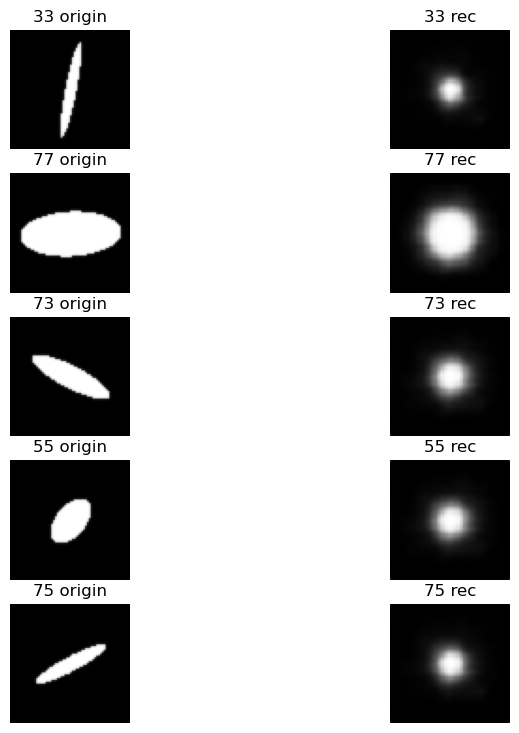

====> PCAAE1 Epoch: 5 Train loss: 0.001226,	 Train Data loss: 0.001226,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 5 Test loss: 0.001276,	 Test Data loss: 0.001276,	 Tes Cov loss: 0.000000,
checkpoint - step: 1, epoch: 5
parameters are saved 

====> PCAAE1 Epoch: 6 Train loss: 0.001207,	 Train Data loss: 0.001207,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 6 Test loss: 0.001234,	 Test Data loss: 0.001234,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 7 Train loss: 0.001209,	 Train Data loss: 0.001209,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 7 Test loss: 0.001213,	 Test Data loss: 0.001213,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 8 Train loss: 0.001205,	 Train Data loss: 0.001205,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 8 Test loss: 0.001177,	 Test Data loss: 0.001177,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 9 Train loss: 0.001215,	 Train Data loss: 0.001215,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 9 Test loss: 0.001191,	 Test Data loss: 0.001191,	 

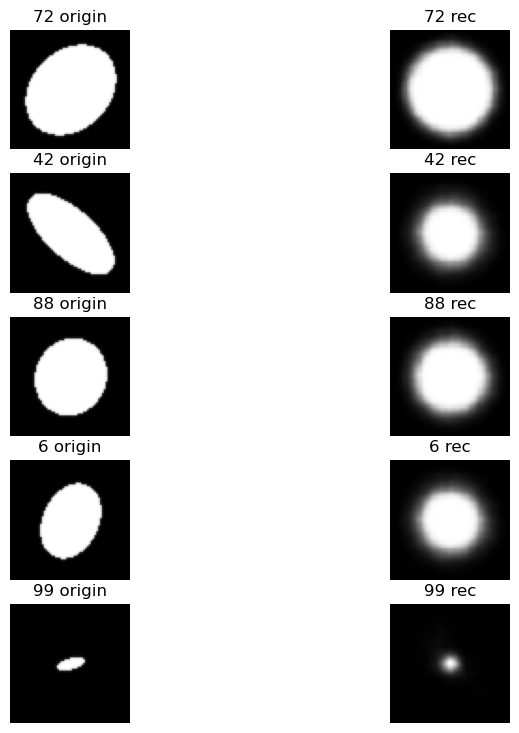

====> PCAAE1 Epoch: 10 Train loss: 0.001199,	 Train Data loss: 0.001199,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 10 Test loss: 0.001175,	 Test Data loss: 0.001175,	 Tes Cov loss: 0.000000,
checkpoint - step: 1, epoch: 10
parameters are saved 

====> PCAAE1 Epoch: 11 Train loss: 0.001200,	 Train Data loss: 0.001200,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 11 Test loss: 0.001182,	 Test Data loss: 0.001182,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 12 Train loss: 0.001201,	 Train Data loss: 0.001201,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 12 Test loss: 0.001250,	 Test Data loss: 0.001250,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 13 Train loss: 0.001203,	 Train Data loss: 0.001203,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 13 Test loss: 0.001182,	 Test Data loss: 0.001182,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 14 Train loss: 0.001197,	 Train Data loss: 0.001197,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 14 Test loss: 0.001165,	 Test Data loss: 

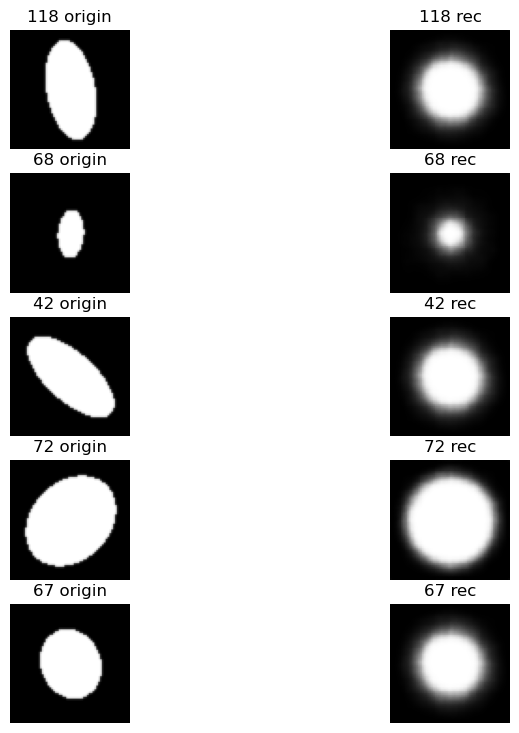

====> PCAAE1 Epoch: 15 Train loss: 0.001194,	 Train Data loss: 0.001194,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 15 Test loss: 0.001173,	 Test Data loss: 0.001173,	 Tes Cov loss: 0.000000,
checkpoint - step: 1, epoch: 15
parameters are saved 

====> PCAAE1 Epoch: 16 Train loss: 0.001190,	 Train Data loss: 0.001190,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 16 Test loss: 0.001185,	 Test Data loss: 0.001185,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 17 Train loss: 0.001195,	 Train Data loss: 0.001195,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 17 Test loss: 0.001168,	 Test Data loss: 0.001168,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 18 Train loss: 0.001194,	 Train Data loss: 0.001194,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 18 Test loss: 0.001175,	 Test Data loss: 0.001175,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 19 Train loss: 0.001192,	 Train Data loss: 0.001192,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 19 Test loss: 0.001467,	 Test Data loss: 

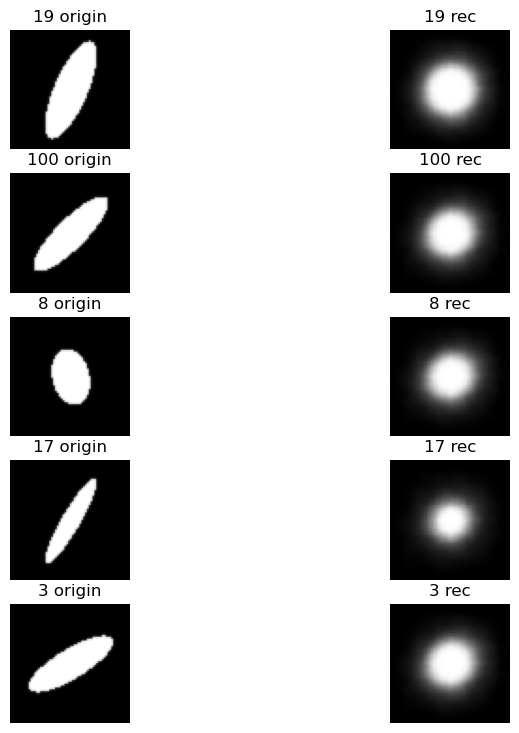

====> PCAAE1 Epoch: 20 Train loss: 0.001192,	 Train Data loss: 0.001192,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 20 Test loss: 0.001251,	 Test Data loss: 0.001251,	 Tes Cov loss: 0.000000,
checkpoint - step: 1, epoch: 20
parameters are saved 

====> PCAAE1 Epoch: 21 Train loss: 0.001191,	 Train Data loss: 0.001191,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 21 Test loss: 0.001180,	 Test Data loss: 0.001180,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 22 Train loss: 0.001190,	 Train Data loss: 0.001190,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 22 Test loss: 0.001404,	 Test Data loss: 0.001404,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 23 Train loss: 0.001191,	 Train Data loss: 0.001191,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 23 Test loss: 0.001239,	 Test Data loss: 0.001239,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 24 Train loss: 0.001187,	 Train Data loss: 0.001187,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 24 Test loss: 0.001172,	 Test Data loss: 

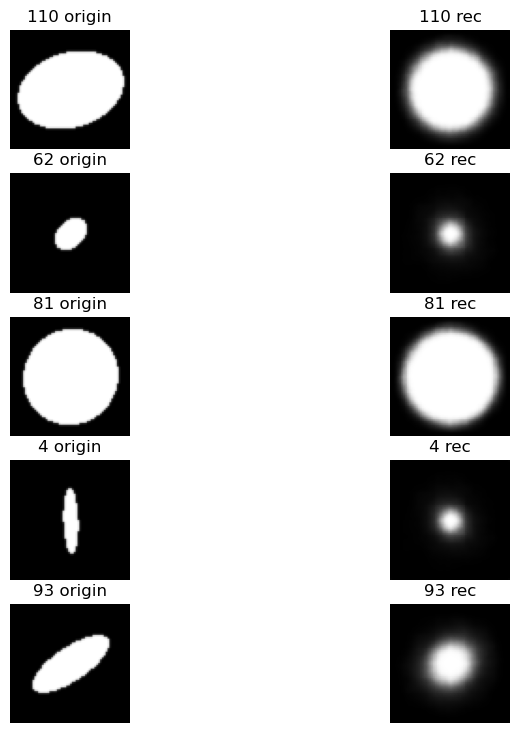

====> PCAAE1 Epoch: 25 Train loss: 0.001190,	 Train Data loss: 0.001190,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 25 Test loss: 0.001166,	 Test Data loss: 0.001166,	 Tes Cov loss: 0.000000,
checkpoint - step: 1, epoch: 25
parameters are saved 

====> PCAAE1 Epoch: 26 Train loss: 0.001194,	 Train Data loss: 0.001194,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 26 Test loss: 0.001193,	 Test Data loss: 0.001193,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 27 Train loss: 0.001192,	 Train Data loss: 0.001192,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 27 Test loss: 0.001174,	 Test Data loss: 0.001174,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 28 Train loss: 0.001192,	 Train Data loss: 0.001192,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 28 Test loss: 0.001284,	 Test Data loss: 0.001284,	 Tes Cov loss: 0.000000,
====> PCAAE1 Epoch: 29 Train loss: 0.001189,	 Train Data loss: 0.001189,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 29 Test loss: 0.001175,	 Test Data loss: 

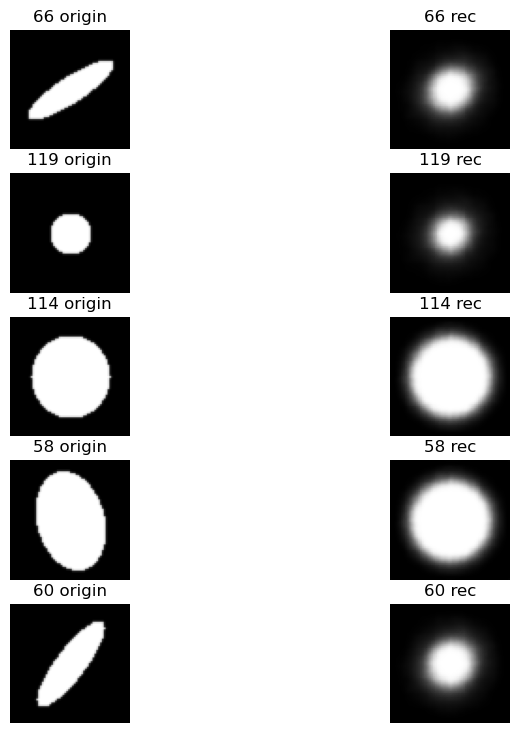

====> PCAAE1 Epoch: 30 Train loss: 0.001188,	 Train Data loss: 0.001188,	 Train Cov loss: 0.000000,
====> PCAAE1 Epoch: 30 Test loss: 0.001168,	 Test Data loss: 0.001168,	 Tes Cov loss: 0.000000,
checkpoint - step: 1, epoch: 30
parameters are saved 

====> PCAAE2 Epoch: 1 Train loss: 0.001830,	 Train Data loss: 0.001643,	 Train Cov loss: 0.000187,
====> PCAAE2 Epoch: 1 Test loss: 0.001027,	 Test Data loss: 0.000940,	 Tes Cov loss: 0.000087,
====> PCAAE2 Epoch: 2 Train loss: 0.001008,	 Train Data loss: 0.000899,	 Train Cov loss: 0.000109,
====> PCAAE2 Epoch: 2 Test loss: 0.000980,	 Test Data loss: 0.000888,	 Tes Cov loss: 0.000092,
====> PCAAE2 Epoch: 3 Train loss: 0.000926,	 Train Data loss: 0.000851,	 Train Cov loss: 0.000075,
====> PCAAE2 Epoch: 3 Test loss: 0.000932,	 Test Data loss: 0.000838,	 Tes Cov loss: 0.000093,
====> PCAAE2 Epoch: 4 Train loss: 0.000905,	 Train Data loss: 0.000826,	 Train Cov loss: 0.000079,
====> PCAAE2 Epoch: 4 Test loss: 0.000937,	 Test Data loss: 0.000824

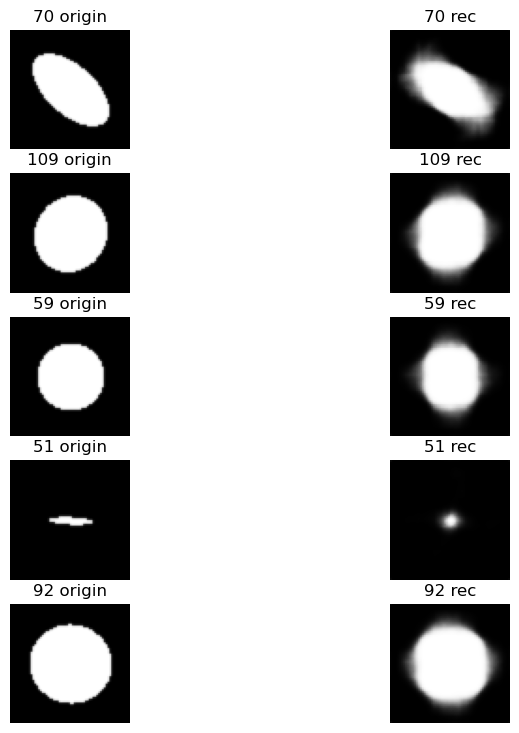

====> PCAAE2 Epoch: 5 Train loss: 0.000890,	 Train Data loss: 0.000810,	 Train Cov loss: 0.000080,
====> PCAAE2 Epoch: 5 Test loss: 0.000896,	 Test Data loss: 0.000807,	 Tes Cov loss: 0.000089,
checkpoint - step: 2, epoch: 5
parameters are saved 

====> PCAAE2 Epoch: 6 Train loss: 0.000862,	 Train Data loss: 0.000798,	 Train Cov loss: 0.000064,
====> PCAAE2 Epoch: 6 Test loss: 0.000881,	 Test Data loss: 0.000803,	 Tes Cov loss: 0.000078,
====> PCAAE2 Epoch: 7 Train loss: 0.000868,	 Train Data loss: 0.000791,	 Train Cov loss: 0.000077,
====> PCAAE2 Epoch: 7 Test loss: 0.000858,	 Test Data loss: 0.000789,	 Tes Cov loss: 0.000069,
====> PCAAE2 Epoch: 8 Train loss: 0.000851,	 Train Data loss: 0.000783,	 Train Cov loss: 0.000068,
====> PCAAE2 Epoch: 8 Test loss: 0.000883,	 Test Data loss: 0.000784,	 Tes Cov loss: 0.000099,
====> PCAAE2 Epoch: 9 Train loss: 0.000839,	 Train Data loss: 0.000774,	 Train Cov loss: 0.000065,
====> PCAAE2 Epoch: 9 Test loss: 0.000858,	 Test Data loss: 0.000781,	 

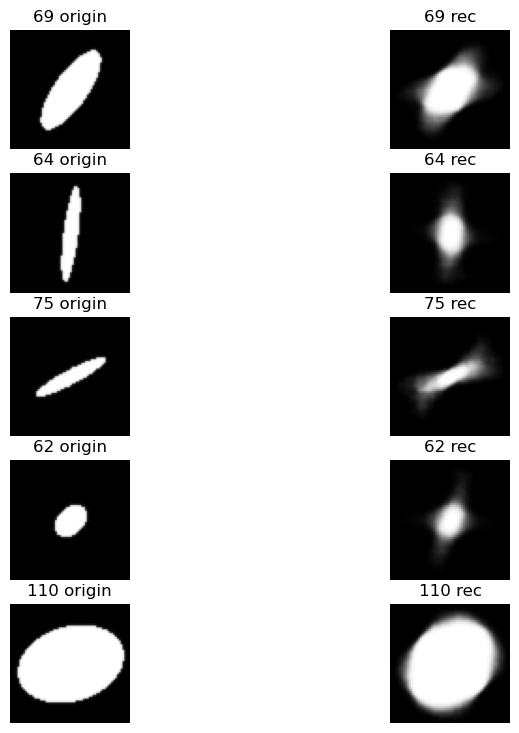

====> PCAAE2 Epoch: 10 Train loss: 0.000839,	 Train Data loss: 0.000767,	 Train Cov loss: 0.000072,
====> PCAAE2 Epoch: 10 Test loss: 0.000874,	 Test Data loss: 0.000797,	 Tes Cov loss: 0.000077,
checkpoint - step: 2, epoch: 10
parameters are saved 

====> PCAAE2 Epoch: 11 Train loss: 0.000827,	 Train Data loss: 0.000761,	 Train Cov loss: 0.000067,
====> PCAAE2 Epoch: 11 Test loss: 0.000816,	 Test Data loss: 0.000761,	 Tes Cov loss: 0.000055,
====> PCAAE2 Epoch: 12 Train loss: 0.000823,	 Train Data loss: 0.000762,	 Train Cov loss: 0.000062,
====> PCAAE2 Epoch: 12 Test loss: 0.000868,	 Test Data loss: 0.000749,	 Tes Cov loss: 0.000120,
====> PCAAE2 Epoch: 13 Train loss: 0.000804,	 Train Data loss: 0.000752,	 Train Cov loss: 0.000051,
====> PCAAE2 Epoch: 13 Test loss: 0.000798,	 Test Data loss: 0.000743,	 Tes Cov loss: 0.000055,
====> PCAAE2 Epoch: 14 Train loss: 0.000805,	 Train Data loss: 0.000747,	 Train Cov loss: 0.000058,
====> PCAAE2 Epoch: 14 Test loss: 0.000829,	 Test Data loss: 

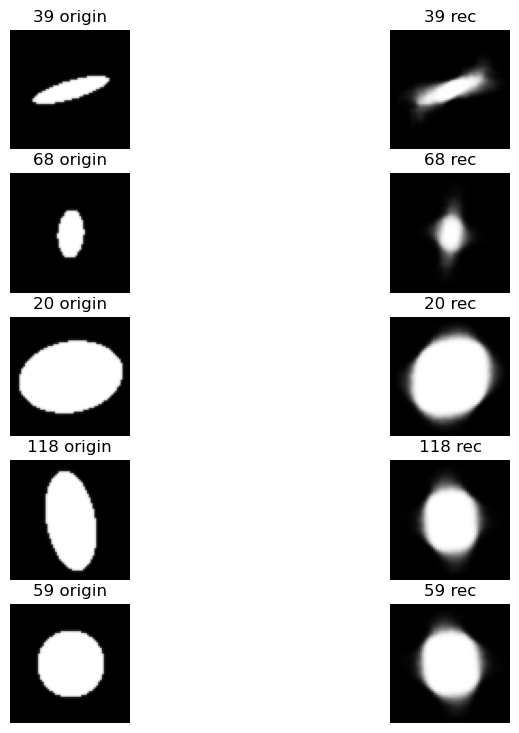

====> PCAAE2 Epoch: 15 Train loss: 0.000808,	 Train Data loss: 0.000745,	 Train Cov loss: 0.000062,
====> PCAAE2 Epoch: 15 Test loss: 0.000790,	 Test Data loss: 0.000732,	 Tes Cov loss: 0.000058,
checkpoint - step: 2, epoch: 15
parameters are saved 

====> PCAAE2 Epoch: 16 Train loss: 0.000804,	 Train Data loss: 0.000741,	 Train Cov loss: 0.000063,
====> PCAAE2 Epoch: 16 Test loss: 0.000785,	 Test Data loss: 0.000730,	 Tes Cov loss: 0.000056,
====> PCAAE2 Epoch: 17 Train loss: 0.000809,	 Train Data loss: 0.000742,	 Train Cov loss: 0.000067,
====> PCAAE2 Epoch: 17 Test loss: 0.000815,	 Test Data loss: 0.000725,	 Tes Cov loss: 0.000091,
====> PCAAE2 Epoch: 18 Train loss: 0.000803,	 Train Data loss: 0.000737,	 Train Cov loss: 0.000066,
====> PCAAE2 Epoch: 18 Test loss: 0.000860,	 Test Data loss: 0.000737,	 Tes Cov loss: 0.000123,
====> PCAAE2 Epoch: 19 Train loss: 0.000799,	 Train Data loss: 0.000737,	 Train Cov loss: 0.000061,
====> PCAAE2 Epoch: 19 Test loss: 0.000776,	 Test Data loss: 

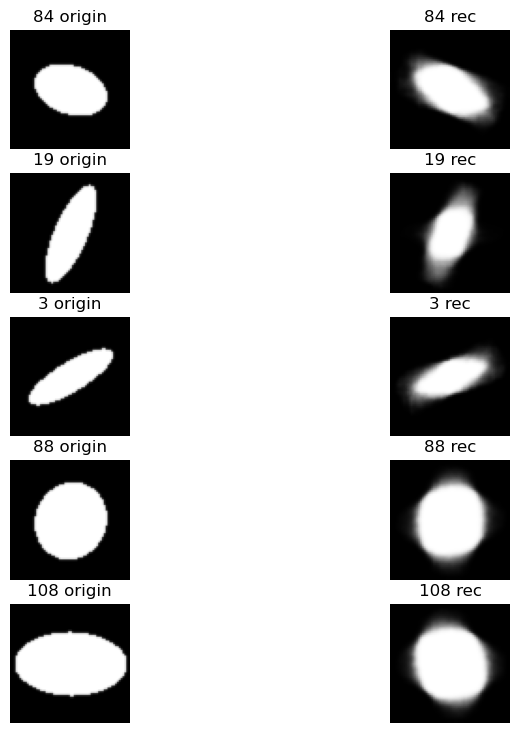

====> PCAAE2 Epoch: 20 Train loss: 0.000794,	 Train Data loss: 0.000736,	 Train Cov loss: 0.000058,
====> PCAAE2 Epoch: 20 Test loss: 0.000778,	 Test Data loss: 0.000717,	 Tes Cov loss: 0.000061,
checkpoint - step: 2, epoch: 20
parameters are saved 

====> PCAAE2 Epoch: 21 Train loss: 0.000787,	 Train Data loss: 0.000731,	 Train Cov loss: 0.000056,
====> PCAAE2 Epoch: 21 Test loss: 0.000804,	 Test Data loss: 0.000717,	 Tes Cov loss: 0.000087,
====> PCAAE2 Epoch: 22 Train loss: 0.000778,	 Train Data loss: 0.000725,	 Train Cov loss: 0.000053,
====> PCAAE2 Epoch: 22 Test loss: 0.000764,	 Test Data loss: 0.000712,	 Tes Cov loss: 0.000052,
====> PCAAE2 Epoch: 23 Train loss: 0.000791,	 Train Data loss: 0.000732,	 Train Cov loss: 0.000059,
====> PCAAE2 Epoch: 23 Test loss: 0.000781,	 Test Data loss: 0.000720,	 Tes Cov loss: 0.000061,
====> PCAAE2 Epoch: 24 Train loss: 0.000778,	 Train Data loss: 0.000719,	 Train Cov loss: 0.000059,
====> PCAAE2 Epoch: 24 Test loss: 0.000777,	 Test Data loss: 

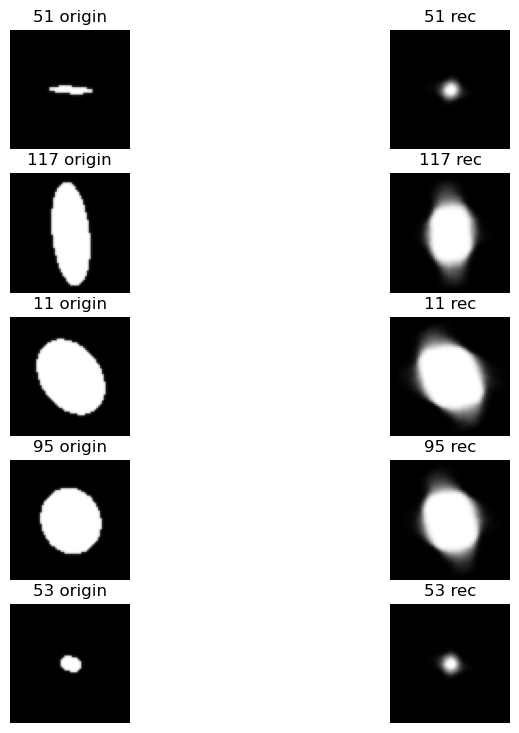

====> PCAAE2 Epoch: 25 Train loss: 0.000779,	 Train Data loss: 0.000722,	 Train Cov loss: 0.000057,
====> PCAAE2 Epoch: 25 Test loss: 0.000760,	 Test Data loss: 0.000705,	 Tes Cov loss: 0.000055,
checkpoint - step: 2, epoch: 25
parameters are saved 

====> PCAAE2 Epoch: 26 Train loss: 0.000779,	 Train Data loss: 0.000720,	 Train Cov loss: 0.000059,
====> PCAAE2 Epoch: 26 Test loss: 0.000764,	 Test Data loss: 0.000698,	 Tes Cov loss: 0.000066,
====> PCAAE2 Epoch: 27 Train loss: 0.000781,	 Train Data loss: 0.000723,	 Train Cov loss: 0.000058,
====> PCAAE2 Epoch: 27 Test loss: 0.000759,	 Test Data loss: 0.000698,	 Tes Cov loss: 0.000061,
====> PCAAE2 Epoch: 28 Train loss: 0.000776,	 Train Data loss: 0.000722,	 Train Cov loss: 0.000054,
====> PCAAE2 Epoch: 28 Test loss: 0.000758,	 Test Data loss: 0.000701,	 Tes Cov loss: 0.000057,
====> PCAAE2 Epoch: 29 Train loss: 0.000782,	 Train Data loss: 0.000719,	 Train Cov loss: 0.000063,
====> PCAAE2 Epoch: 29 Test loss: 0.000775,	 Test Data loss: 

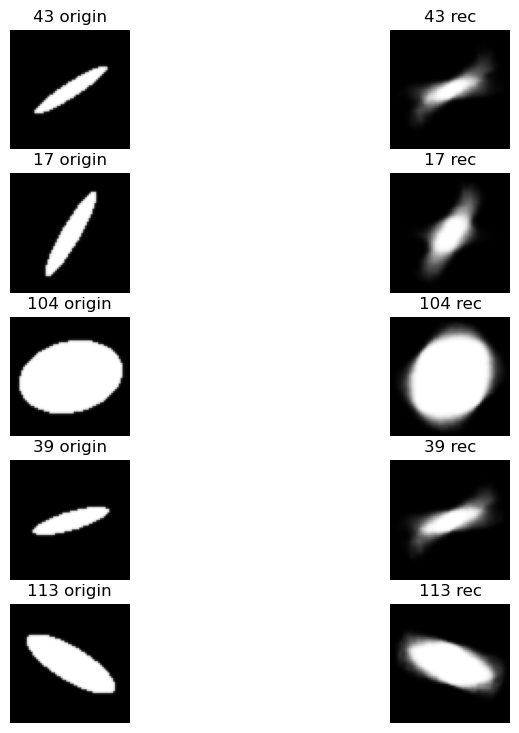

====> PCAAE2 Epoch: 30 Train loss: 0.000765,	 Train Data loss: 0.000711,	 Train Cov loss: 0.000053,
====> PCAAE2 Epoch: 30 Test loss: 0.000807,	 Test Data loss: 0.000727,	 Tes Cov loss: 0.000080,
checkpoint - step: 2, epoch: 30
parameters are saved 

====> PCAAE3 Epoch: 1 Train loss: 0.001854,	 Train Data loss: 0.001482,	 Train Cov loss: 0.000372,
====> PCAAE3 Epoch: 1 Test loss: 0.000940,	 Test Data loss: 0.000806,	 Tes Cov loss: 0.000133,
====> PCAAE3 Epoch: 2 Train loss: 0.000819,	 Train Data loss: 0.000704,	 Train Cov loss: 0.000115,
====> PCAAE3 Epoch: 2 Test loss: 0.000777,	 Test Data loss: 0.000651,	 Tes Cov loss: 0.000126,
====> PCAAE3 Epoch: 3 Train loss: 0.000716,	 Train Data loss: 0.000622,	 Train Cov loss: 0.000094,
====> PCAAE3 Epoch: 3 Test loss: 0.000695,	 Test Data loss: 0.000594,	 Tes Cov loss: 0.000101,
====> PCAAE3 Epoch: 4 Train loss: 0.000652,	 Train Data loss: 0.000575,	 Train Cov loss: 0.000078,
====> PCAAE3 Epoch: 4 Test loss: 0.000688,	 Test Data loss: 0.000553

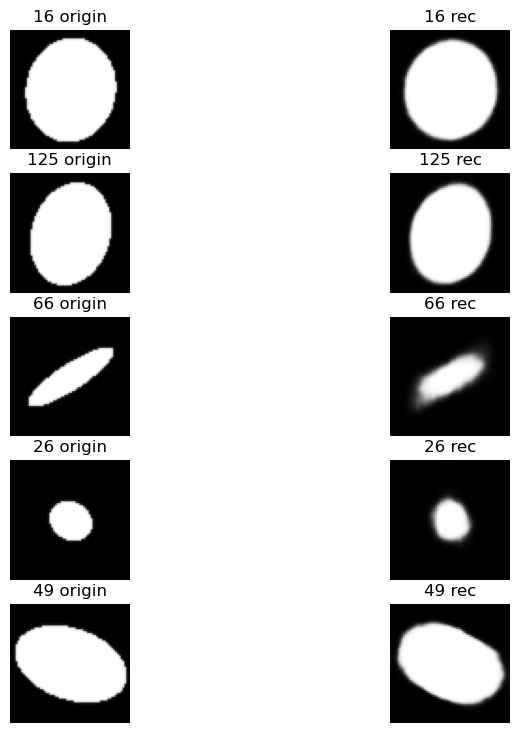

====> PCAAE3 Epoch: 5 Train loss: 0.000603,	 Train Data loss: 0.000539,	 Train Cov loss: 0.000064,
====> PCAAE3 Epoch: 5 Test loss: 0.000611,	 Test Data loss: 0.000500,	 Tes Cov loss: 0.000112,
checkpoint - step: 3, epoch: 5
parameters are saved 

====> PCAAE3 Epoch: 6 Train loss: 0.000582,	 Train Data loss: 0.000512,	 Train Cov loss: 0.000070,
====> PCAAE3 Epoch: 6 Test loss: 0.000572,	 Test Data loss: 0.000496,	 Tes Cov loss: 0.000076,
====> PCAAE3 Epoch: 7 Train loss: 0.000573,	 Train Data loss: 0.000498,	 Train Cov loss: 0.000075,
====> PCAAE3 Epoch: 7 Test loss: 0.000557,	 Test Data loss: 0.000497,	 Tes Cov loss: 0.000061,
====> PCAAE3 Epoch: 8 Train loss: 0.000536,	 Train Data loss: 0.000477,	 Train Cov loss: 0.000059,
====> PCAAE3 Epoch: 8 Test loss: 0.000549,	 Test Data loss: 0.000474,	 Tes Cov loss: 0.000076,
====> PCAAE3 Epoch: 9 Train loss: 0.000529,	 Train Data loss: 0.000462,	 Train Cov loss: 0.000067,
====> PCAAE3 Epoch: 9 Test loss: 0.000520,	 Test Data loss: 0.000458,	 

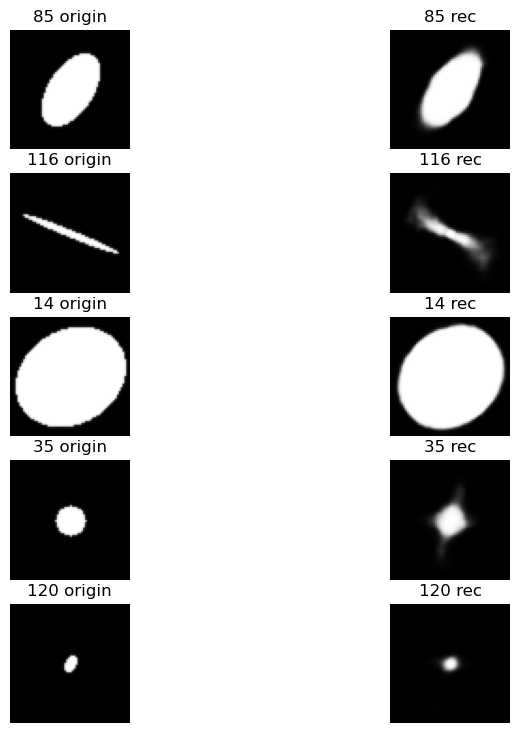

====> PCAAE3 Epoch: 10 Train loss: 0.000505,	 Train Data loss: 0.000444,	 Train Cov loss: 0.000061,
====> PCAAE3 Epoch: 10 Test loss: 0.000494,	 Test Data loss: 0.000419,	 Tes Cov loss: 0.000074,
checkpoint - step: 3, epoch: 10
parameters are saved 

====> PCAAE3 Epoch: 11 Train loss: 0.000501,	 Train Data loss: 0.000439,	 Train Cov loss: 0.000062,
====> PCAAE3 Epoch: 11 Test loss: 0.000474,	 Test Data loss: 0.000409,	 Tes Cov loss: 0.000066,
====> PCAAE3 Epoch: 12 Train loss: 0.000483,	 Train Data loss: 0.000427,	 Train Cov loss: 0.000056,
====> PCAAE3 Epoch: 12 Test loss: 0.000446,	 Test Data loss: 0.000378,	 Tes Cov loss: 0.000068,
====> PCAAE3 Epoch: 13 Train loss: 0.000470,	 Train Data loss: 0.000412,	 Train Cov loss: 0.000058,
====> PCAAE3 Epoch: 13 Test loss: 0.000502,	 Test Data loss: 0.000397,	 Tes Cov loss: 0.000105,
====> PCAAE3 Epoch: 14 Train loss: 0.000468,	 Train Data loss: 0.000405,	 Train Cov loss: 0.000062,
====> PCAAE3 Epoch: 14 Test loss: 0.000441,	 Test Data loss: 

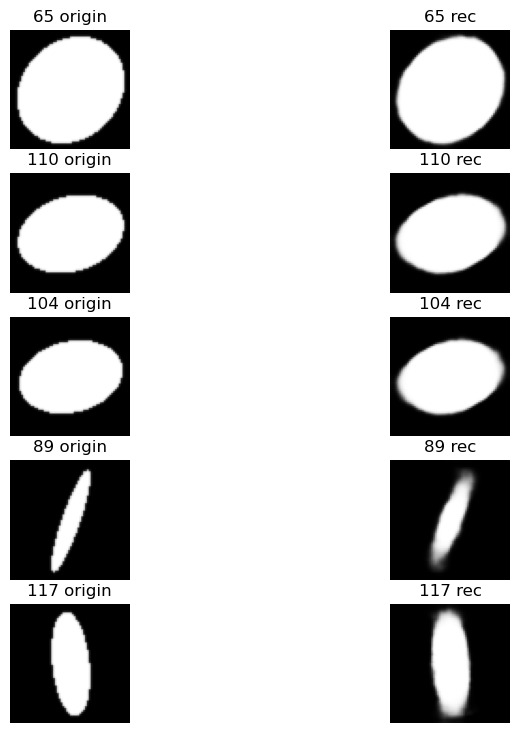

====> PCAAE3 Epoch: 15 Train loss: 0.000459,	 Train Data loss: 0.000400,	 Train Cov loss: 0.000059,
====> PCAAE3 Epoch: 15 Test loss: 0.000442,	 Test Data loss: 0.000361,	 Tes Cov loss: 0.000082,
checkpoint - step: 3, epoch: 15
parameters are saved 

====> PCAAE3 Epoch: 16 Train loss: 0.000458,	 Train Data loss: 0.000395,	 Train Cov loss: 0.000062,
====> PCAAE3 Epoch: 16 Test loss: 0.000427,	 Test Data loss: 0.000357,	 Tes Cov loss: 0.000070,
====> PCAAE3 Epoch: 17 Train loss: 0.000444,	 Train Data loss: 0.000387,	 Train Cov loss: 0.000057,
====> PCAAE3 Epoch: 17 Test loss: 0.000429,	 Test Data loss: 0.000368,	 Tes Cov loss: 0.000061,
====> PCAAE3 Epoch: 18 Train loss: 0.000444,	 Train Data loss: 0.000384,	 Train Cov loss: 0.000060,
====> PCAAE3 Epoch: 18 Test loss: 0.000408,	 Test Data loss: 0.000346,	 Tes Cov loss: 0.000062,
====> PCAAE3 Epoch: 19 Train loss: 0.000430,	 Train Data loss: 0.000374,	 Train Cov loss: 0.000056,
====> PCAAE3 Epoch: 19 Test loss: 0.000449,	 Test Data loss: 

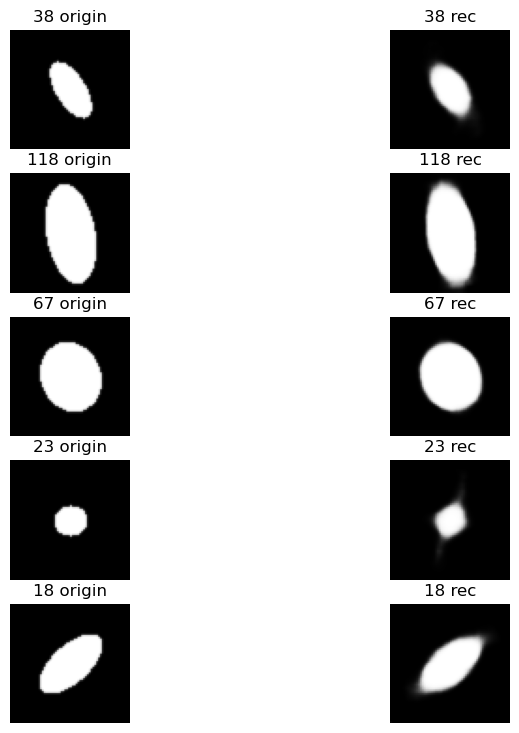

====> PCAAE3 Epoch: 20 Train loss: 0.000431,	 Train Data loss: 0.000373,	 Train Cov loss: 0.000057,
====> PCAAE3 Epoch: 20 Test loss: 0.000402,	 Test Data loss: 0.000332,	 Tes Cov loss: 0.000070,
checkpoint - step: 3, epoch: 20
parameters are saved 

====> PCAAE3 Epoch: 21 Train loss: 0.000432,	 Train Data loss: 0.000369,	 Train Cov loss: 0.000063,
====> PCAAE3 Epoch: 21 Test loss: 0.000392,	 Test Data loss: 0.000341,	 Tes Cov loss: 0.000052,
====> PCAAE3 Epoch: 22 Train loss: 0.000429,	 Train Data loss: 0.000365,	 Train Cov loss: 0.000063,
====> PCAAE3 Epoch: 22 Test loss: 0.000385,	 Test Data loss: 0.000334,	 Tes Cov loss: 0.000051,
====> PCAAE3 Epoch: 23 Train loss: 0.000419,	 Train Data loss: 0.000362,	 Train Cov loss: 0.000057,
====> PCAAE3 Epoch: 23 Test loss: 0.000395,	 Test Data loss: 0.000339,	 Tes Cov loss: 0.000056,
====> PCAAE3 Epoch: 24 Train loss: 0.000406,	 Train Data loss: 0.000354,	 Train Cov loss: 0.000052,
====> PCAAE3 Epoch: 24 Test loss: 0.000396,	 Test Data loss: 

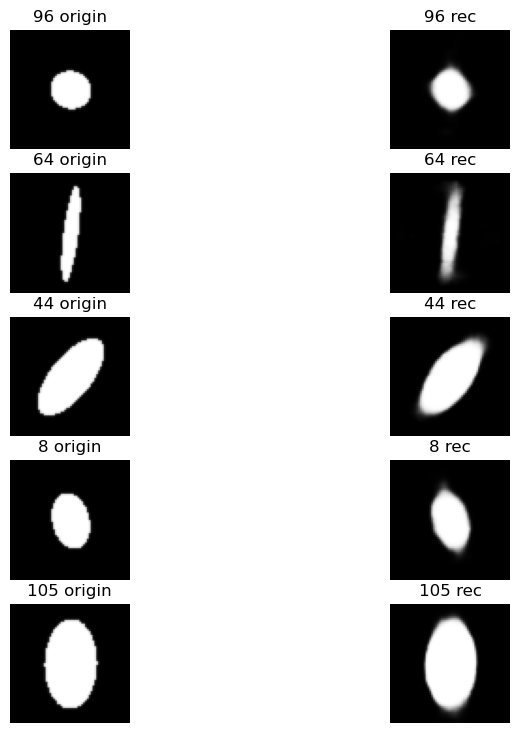

====> PCAAE3 Epoch: 25 Train loss: 0.000401,	 Train Data loss: 0.000352,	 Train Cov loss: 0.000049,
====> PCAAE3 Epoch: 25 Test loss: 0.000389,	 Test Data loss: 0.000330,	 Tes Cov loss: 0.000059,
checkpoint - step: 3, epoch: 25
parameters are saved 

====> PCAAE3 Epoch: 26 Train loss: 0.000415,	 Train Data loss: 0.000356,	 Train Cov loss: 0.000058,
====> PCAAE3 Epoch: 26 Test loss: 0.000429,	 Test Data loss: 0.000365,	 Tes Cov loss: 0.000064,
====> PCAAE3 Epoch: 27 Train loss: 0.000401,	 Train Data loss: 0.000345,	 Train Cov loss: 0.000056,
====> PCAAE3 Epoch: 27 Test loss: 0.000400,	 Test Data loss: 0.000330,	 Tes Cov loss: 0.000070,
====> PCAAE3 Epoch: 28 Train loss: 0.000403,	 Train Data loss: 0.000346,	 Train Cov loss: 0.000057,
====> PCAAE3 Epoch: 28 Test loss: 0.000377,	 Test Data loss: 0.000310,	 Tes Cov loss: 0.000067,
====> PCAAE3 Epoch: 29 Train loss: 0.000409,	 Train Data loss: 0.000345,	 Train Cov loss: 0.000064,
====> PCAAE3 Epoch: 29 Test loss: 0.000377,	 Test Data loss: 

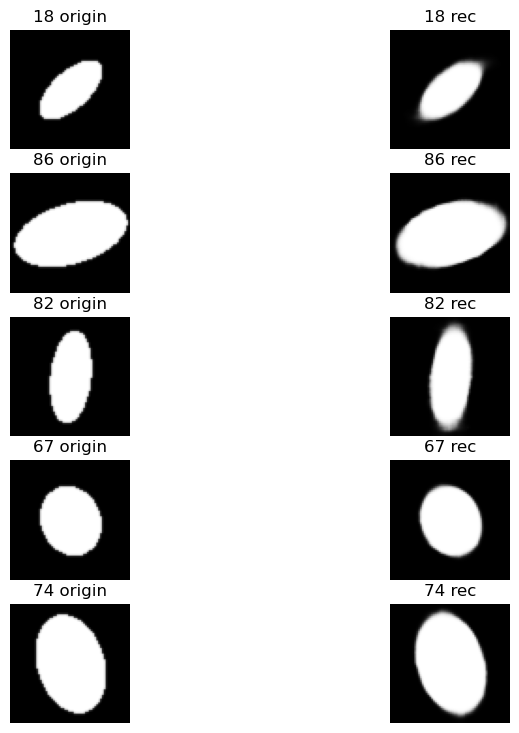

====> PCAAE3 Epoch: 30 Train loss: 0.000377,	 Train Data loss: 0.000333,	 Train Cov loss: 0.000044,
====> PCAAE3 Epoch: 30 Test loss: 0.000384,	 Test Data loss: 0.000303,	 Tes Cov loss: 0.000082,
checkpoint - step: 3, epoch: 30
parameters are saved 



In [16]:
PCAAE_path = './imit_models/PCAAE/'
if os.path.exists(PCAAE_path) is False:
    os.makedirs(PCAAE_path)
model_path_list = sorted(glob(f'{PCAAE_path}PCAAE*'), key=len)

if len(model_path_list) != 0:
    print('A trained model is found')
    is_training = False
    model_path = model_path_list[-1]    

if use_gpu:
    PCAAE_model.to_gpu()
    train_loader.to_gpu()
    test_loader.to_gpu()
    print('use gpu')
else:
    print('use cpu')
    
if is_training:
    print("Training PCA-AE for ellipses", '\n')
    for step in range(1, train_latent+1):
        present_optim = PCAAE_optimizers[step-1]
        PCAAE_optim = present_optim.setup(PCAAE_model)
        for epoch in range(1, num_epoch + 1):
            train_PCA_AE(PCAAE_model, PCAAE_optim, epoch, step, train_loader, test_loader, lambda_cov=lambda_cov)
        
            if epoch % 5 == 0:
                print(f'checkpoint - step: {step}, epoch: {epoch}')
                filename = f'PCAAE_ellipse_step{step}_epoch{epoch}.npz'
                filepath = os.path.join(PCAAE_path, filename)
                PCAAE_model.save_weights(filepath, BackToTheGPU=True)
                print('parameters are saved', '\n')

else:
    print(f"Load the model: {model_path}")
    PCAAE_model.load_weights(model_path)

output image comparison

In [21]:
simple_AE.to_cpu()
PCAAE_model.to_cpu()

In [22]:
img_plot_size = 5
img_sample_num = int(img_plot_size**2)
figsize=12
sample_list = np.sort(np.random.choice(np.arange(batchsize, dtype=int), size=img_sample_num, replace=False))
sample_list

array([  0,   1,   2,  17,  26,  30,  33,  37,  42,  47,  64,  66,  67,
        71,  73,  74,  81,  90,  92,  98, 102, 103, 112, 114, 123])

In [23]:
def reconstruction_plot(AE, data, test_latent, sample_list, suptitle: str,
                        PCAAE=True, img_plot_size=5, fig_size=12):
    
    plt.figure(figsize=(figsize, figsize))
    with dezero.no_grad():
        for i in range(img_sample_num):
            k = sample_list[i]
            ax = plt.subplot(img_plot_size, img_plot_size, i + 1)
            ax.title.set_text('{}'.format(k))
            
            img = data[k][np.newaxis, :]
            
            if PCAAE:
                z = []
                for jd in range(test_latent-1):
                    z.append(getattr(AE.PCAAE_E, f'PCAAE_E_{jd}')(img).data)
                z_i = getattr(AE.PCAAE_E, f'PCAAE_E_{test_latent-1}')(img).data
                z.append(z_i)
                latent_code = np.concatenate(z, axis=1)
                img_rec = np.squeeze(getattr(AE.PCAAE_D, f'PCAAE_D_{test_latent-1}')(latent_code).data, axis=(0,1))
            else:
                latent_code = AE.encoder(img).data
                img_rec = np.squeeze(AE.decoder(latent_code).data, axis=(0,1))
            
            plt.imshow(img_rec, 'gray')
            plt.axis("off")
            plt.suptitle(f"{suptitle}", fontsize=32)

original images

In [24]:
print(data.shape, type(data))

(128, 1, 64, 64) <class 'numpy.ndarray'>


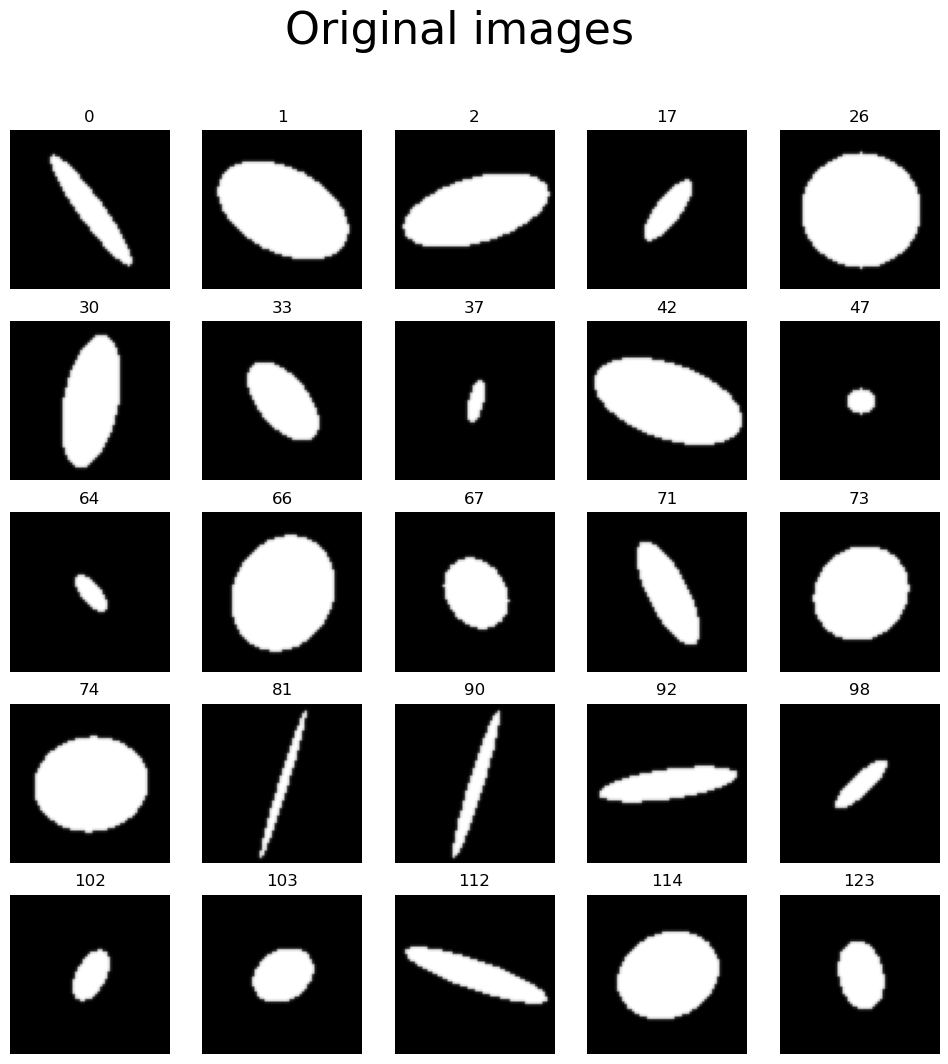

In [25]:
plt.figure(figsize=(figsize, figsize))
for i in range(img_sample_num):
    k = sample_list[i]
    ax = plt.subplot(img_plot_size, img_plot_size, i + 1)
    ax.title.set_text('{}'.format(k))
    img = data[k].reshape(image_size,image_size)
    plt.imshow(img, 'gray')
    plt.axis("off")
    plt.suptitle('Original images', fontsize=32)

simple AE outputs

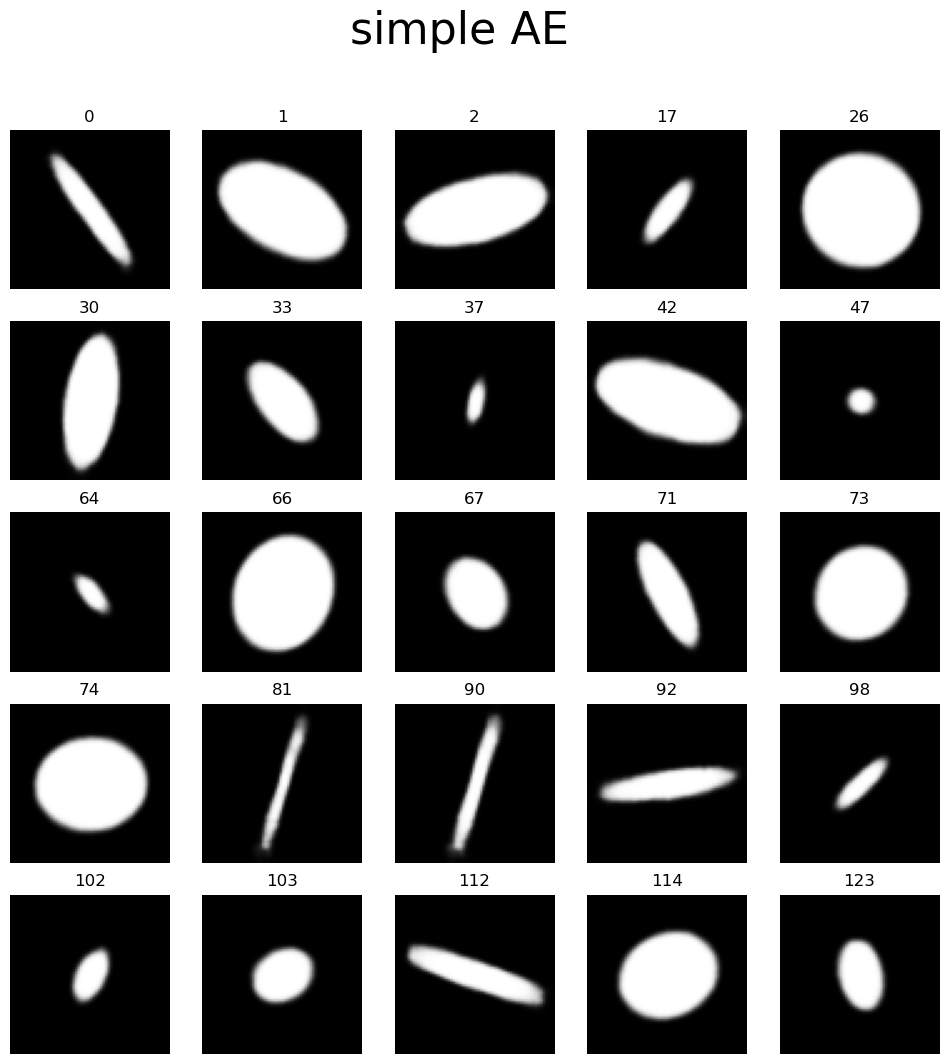

In [26]:
reconstruction_plot(simple_AE, data, test_latent, sample_list, suptitle='simple AE', PCAAE=False)

PCA-AE output

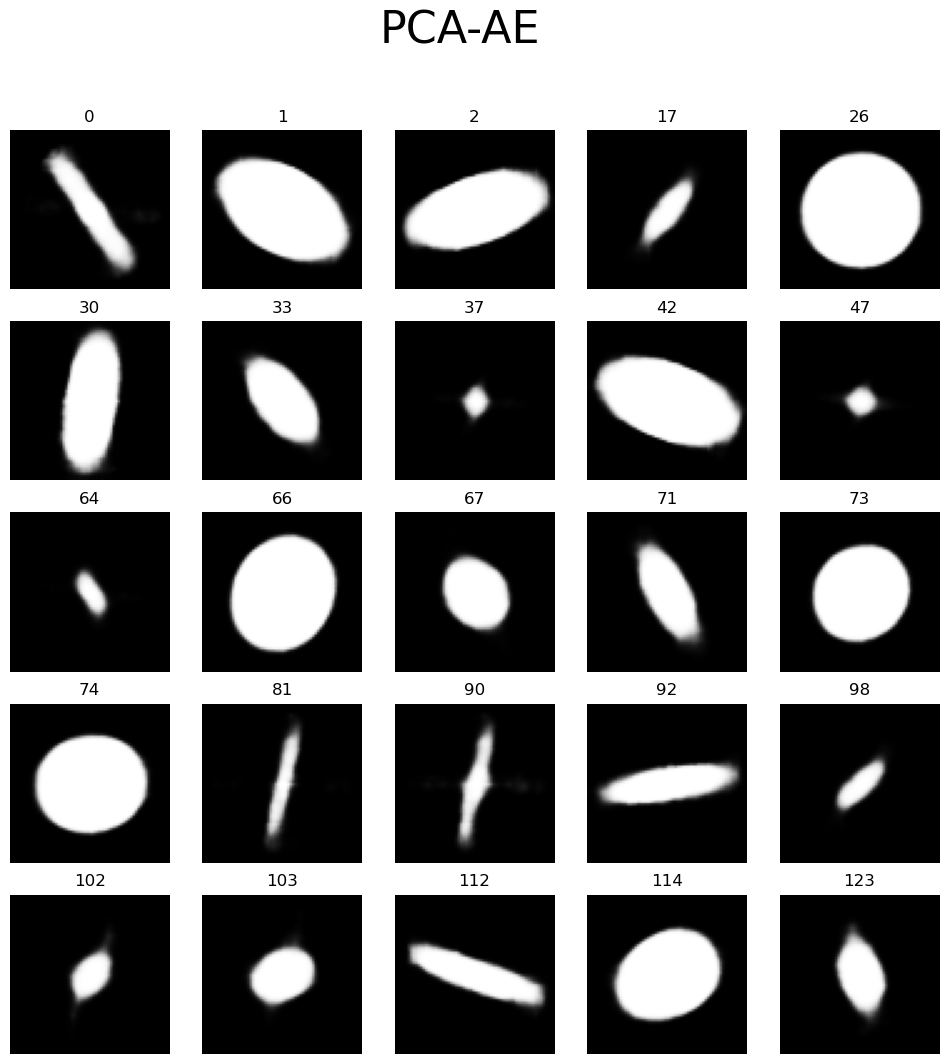

In [27]:
reconstruction_plot(PCAAE_model, data, test_latent, sample_list, suptitle='PCA-AE')

image interpolations from latent space

In [28]:
def latent2plot(decoder, test_latent,
                PCAAE=True, start=-1, end=1, len_plot=7, fig_size=16):
    
    array = np.arange(test_latent, dtype=int).tolist()
    comb = list(itertools.combinations(array, 2))
    
    with dezero.no_grad():
        fig, axes = plt.subplots(test_latent, len_plot, figsize=(fig_size, fig_size))
        for dim in range(test_latent):
            cnt = 0
            for i in np.linspace(start, end, len_plot):
                z = np.zeros(test_latent, dtype=np.float32)
                z[dim] = i
                z = z.reshape(1, -1)
                
                if PCAAE:
                    img = decoder(z, step=test_latent)
                else:
                    img = decoder(z)
                img = np.squeeze(img.data, axis=(0,1))

                ## subplot
                axes[dim, cnt].imshow(img, 'gray')
                axes[dim, cnt].title.set_text(f"z{dim+1} = {np.round(i,2)}")
                axes[dim, cnt].axis('off')
                cnt += 1
        plt.show()

simple AE

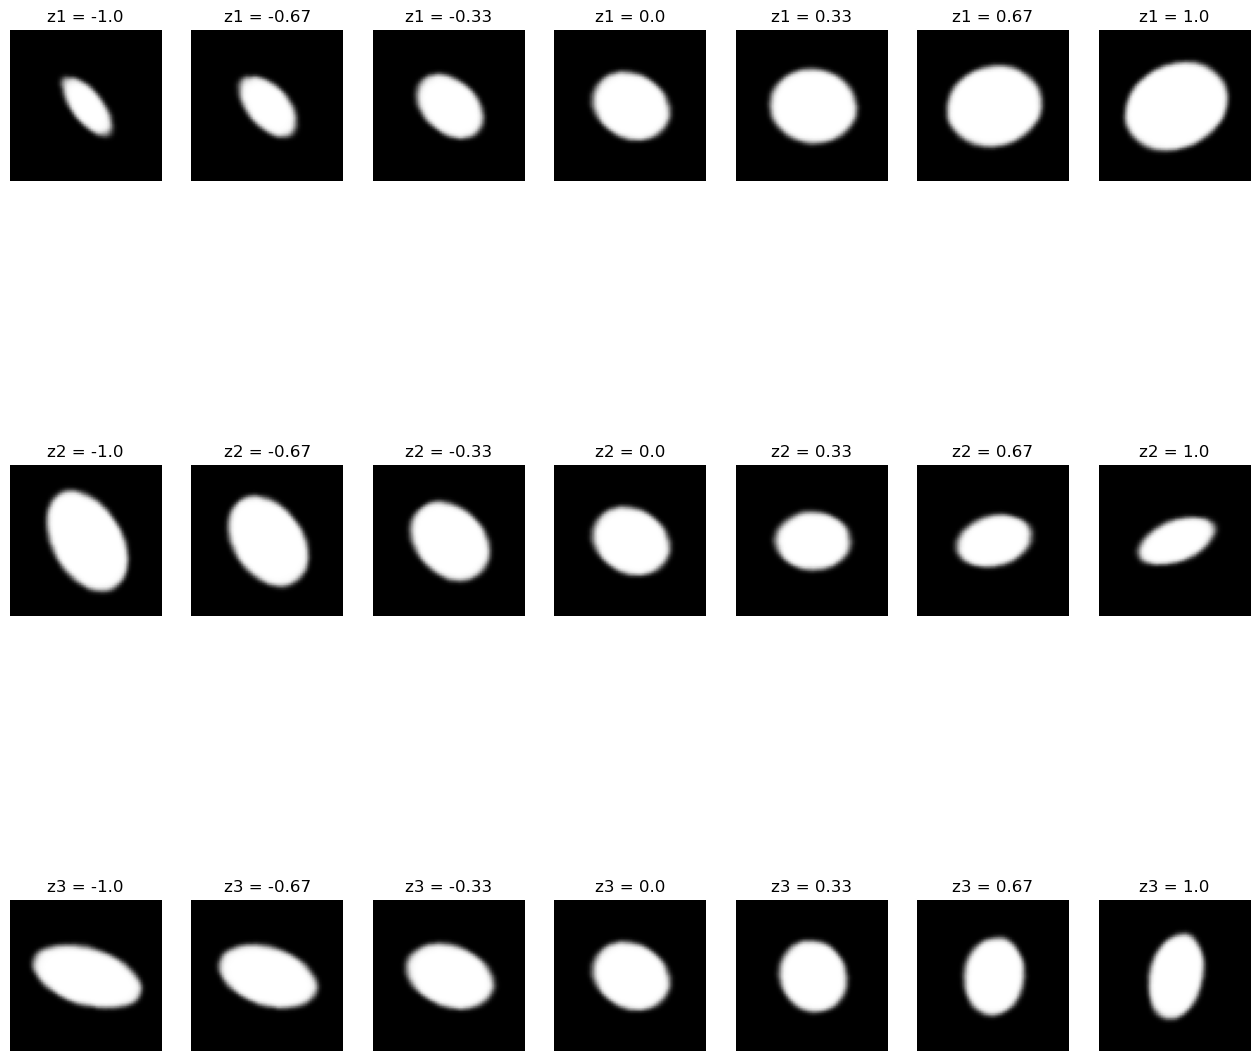

In [29]:
latent2plot(simple_AE.decoder, test_latent, PCAAE=False)

PCA-AE

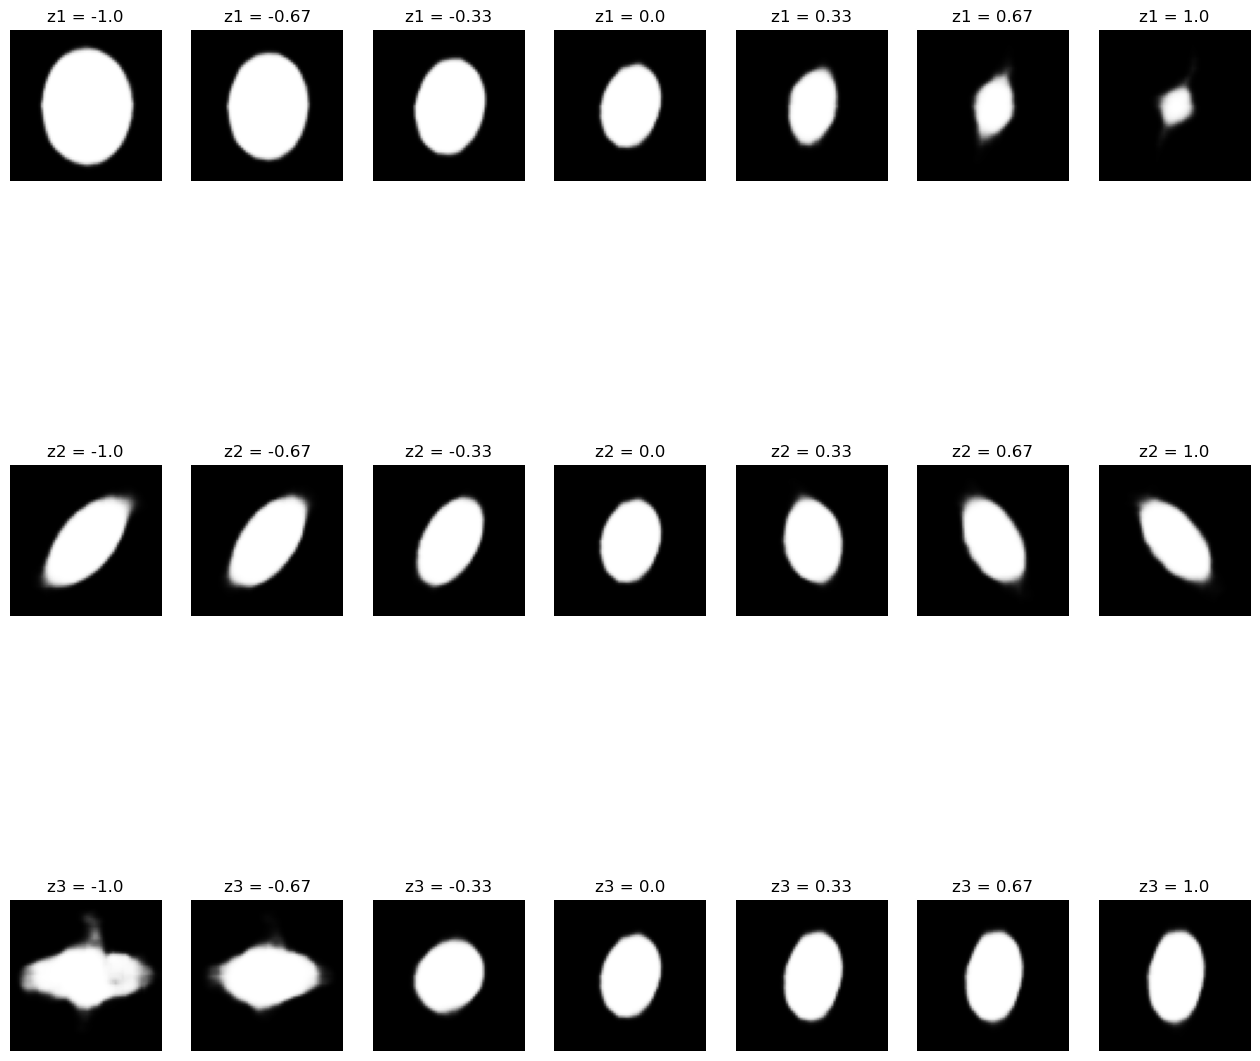

In [30]:
latent2plot(PCAAE_model.PCAAE_D, test_latent)

Pearson correlation coefficient to evaluate models

In [31]:
def correlation(X1,X2):
        X1 = np.squeeze(X1)
        X2 = np.squeeze(X2)
        cov = ((X1-X1.mean())*(X2-X2.mean())).mean()
        cor = cov/(X1.std()*X2.std())
        return np.abs(cor)
    
def evaluation(z,rect): 
    # Latent space 's composants
    z1 = z[:,0]
    z2 = z[:,1]
    z3 = z[:,2]

    # Ellipse area
    S = np.reshape(rect, (-1, 64*64)).sum(axis=-1,keepdims=True)
    # Horizontal axis
    L_1 = np.squeeze(rect)[:, 31, :].sum(axis=-1,keepdims=True)
    # Vertical axis
    L_2 = np.squeeze(rect)[:, :, 31].sum(axis=-1,keepdims=True)
    # Diagonal axis
    L_3 = np.expand_dims(np.concatenate( [np.expand_dims(np.trace(np.squeeze(jd)), axis=0) for jd in rect], axis=0), axis=1)
    # Another diagonal axis
    L_4 = np.expand_dims(np.concatenate( [np.expand_dims(np.trace(np.rot90(np.squeeze(jd))), axis=0) for jd in rect], axis=0), axis=1)
    
    # Horizontal/verical ratio
    H = np.abs(L_1/L_2)
    # Two-diagonal-lines ratio
    V = np.abs(L_3/L_4)
    
    # Correlations
    cor_S1 = correlation(z1,S)
    cor_S2 = correlation(z2,S)
    cor_S3 = correlation(z3,S)
     
    cor_H1 = correlation(z1,H)
    cor_H2 = correlation(z2,H)
    cor_H3 = correlation(z3,H)
    
    cor_V1 = correlation(z1,V)
    cor_V2 = correlation(z2,V)
    cor_V3 = correlation(z3,V)
    
    return np.round(((cor_S1,cor_S2,cor_S3),(cor_H1,cor_H2,cor_H3),(cor_V1,cor_V2,cor_V3)), 4)

compute the latent space

In [37]:
test_dataset = generating_data(1000,image_size=image_size,max_gray=max_gray)
test_dataset = np.stack([i for i in test_dataset])/ max_gray
with dezero.no_grad():
    z_AE = simple_AE.encoder(test_dataset).data
    
    z_PCAAE = np.concatenate((PCAAE_model.PCAAE_E.PCAAE_E_0(test_dataset).data,
                              PCAAE_model.PCAAE_E.PCAAE_E_1(test_dataset).data,
                              PCAAE_model.PCAAE_E.PCAAE_E_2(test_dataset).data,), axis=-1)

show the quantitative results

In [38]:
evaluation(z_AE, test_dataset)

array([[0.8854, 0.7329, 0.4262],
       [0.0422, 0.447 , 0.5306],
       [0.4627, 0.2368, 0.2813]])

In [39]:
evaluation(z_PCAAE, test_dataset)

array([[0.9873, 0.0171, 0.0085],
       [0.1441, 0.074 , 0.2397],
       [0.2127, 0.4266, 0.063 ]])